## **Nightjars - The Dark Detector**
Using Improved **YOLOv8cdark** model and **Intel Optimization Tools**.

#### **Goal & Motivation** : Image enhancement specially in the Low-light conditions & Thermal Imaging.

###### **Live distance estimation, Tracking with DeepSort and Count of the objects under low-light environment.**
---

### **1. Clone the Git Repo & Install Required libraries**


---



In [1]:
!git clone https://github.com/Brindha-m/Nightjars_IntelAI.git

Cloning into 'Nightjars_IntelAI'...
https://git-lfs.github.com/spec/v1 is not a valid attribute name: .gitattributes:1
sha256:9ed692ef76418c1613b984d4abba2af7143b82038e8e06bbe767e7df4e97b677 is not a valid attribute name: .gitattributes:2
Updating files:  97% (135/138)
Updating files:  98% (136/138)
Updating files:  99% (137/138)
Updating files: 100% (138/138)
Updating files: 100% (138/138), done.
Error downloading object: yolov8xcdark_openvino_model/yolov8xcdark.bin (e55725f): Smudge error: Error downloading yolov8xcdark_openvino_model/yolov8xcdark.bin (e55725f1d498852ca4b04caeec2b9e24758004915bac3e99ae108b5e6af9f50a): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to 'C:\Intel\aipcdevkit\openvino_notebooks\Nightjars_IntelAI\.git\lfs\logs\20250516T050805.6143495.log'.
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: yolov8xcdark_op

In [1]:
%cd Nightjars_IntelAI/

C:\Intel\aipcdevkit\openvino_notebooks\Nightjars_IntelAI


C:\Intel\aipcdevkit\aipc-venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install -r requirements.txt --quiet
!pip install --upgrade opencv-python-headless
!pip install modin[ray]
!pip install deep_sort_realtime

ERROR: Ignored the following versions that require a different python version: 0.55.2 Requires-Python <3.5
ERROR: Could not find a version that satisfies the requirement intel-extension-for-pytorch (from versions: none)
ERROR: No matching distribution found for intel-extension-for-pytorch


  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-python-headless-4.10.0.84


### **2. Import Required Libraries**


---



In [3]:
import os
import cv2
import json
import numpy as np
import torch
from collections import deque, Counter
import modin.pandas as pd
import subprocess
import openvino.runtime as ov
from pathlib import Path
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import display
from tqdm.notebook import tqdm as stqdm
from PIL import Image
from ultralytics import YOLO
from ultralytics.engine.results import Results
import time

### **3. Define Utility Functions**


---



In [4]:
# Define COLORS for visualization for image visualization
COLORS = [(255, 115, 100),(133, 0, 82), (255, 56, 203), (56, 56, 255), (151, 157, 255), (31, 112, 255), (29, 178, 255), (49, 210, 207), (10, 249, 72), (23, 204, 146),
          (134, 219, 61), (52, 147, 26), (187, 212, 0), (168, 153, 44), (255, 194, 0), (147, 69, 52),
          (236, 24, 0), (255, 56, 132), (200, 149, 255), (199, 55, 255)]

def result_to_json(result: Results, tracker=None):
    """
    Convert result from ultralytics YOLOv8 prediction to json format
    Parameters:
        result: Results from ultralytics YOLOv8 prediction
        tracker: DeepSort tracker
    Returns:
        result_list_json: detection result in json format
    """
    len_results = len(result.boxes)
    result_list_json = [
        {
            'class_id': int(result.boxes.cls[idx]),
            'class': result.names[int(result.boxes.cls[idx])],
            'confidence': float(result.boxes.conf[idx]),
            'bbox': {
                'x_min': int(result.boxes.xyxy[idx][0]),
                'y_min': int(result.boxes.xyxy[idx][1]),
                'x_max': int(result.boxes.xyxy[idx][2]),
                'y_max': int(result.boxes.xyxy[idx][3]),
            },
        } for idx in range(len_results)
    ]

    if result.masks is not None:
       for idx in range(len_results):
           result_list_json[idx]['mask'] = cv2.resize(result.masks.data[idx].cpu().numpy(),(result.orig_shape[1], result.orig_shape[0])).tolist()
           result_list_json[idx]['segments'] = [seg.tolist() for seg in result.masks.xy[idx]]

    if tracker is not None:
        bbs = [
            (
                [
                    result_list_json[idx]['bbox']['x_min'],
                    result_list_json[idx]['bbox']['y_min'],
                    result_list_json[idx]['bbox']['x_max'] - result_list_json[idx]['bbox']['x_min'],
                    result_list_json[idx]['bbox']['y_max'] - result_list_json[idx]['bbox']['y_min']
                ],
                result_list_json[idx]['confidence'],
                result_list_json[idx]['class'],
            ) for idx in range(len_results)
        ]
        tracks = tracker.update_tracks(bbs, frame=result.orig_img)
        for idx in range(len(result_list_json)):
            track_idx = next((i for i, track in enumerate(tracks) if track.det_conf is not None and np.isclose(track.det_conf, result_list_json[idx]['confidence'])), -1)
            if track_idx != -1:
                result_list_json[idx]['object_id'] = int(tracks[track_idx].track_id)
    return result_list_json

def view_result_ultralytics(result: Results, result_list_json, centers=None):
    """
    Visualize result from ultralytics YOLOv8 prediction using ultralytics YOLOv8 built-in visualization function
    Parameters:
        result: Results from ultralytics YOLOv8 prediction
        result_list_json: detection result in json format
        centers: list of deque of center points of bounding boxes
    Returns:
        result_image_ultralytics: result image from ultralytics YOLOv8 built-in visualization function
    """
    result_image_ultralytics = result.plot()
    for result_json in result_list_json:
        class_color = COLORS[result_json['class_id'] % len(COLORS)]
        if 'object_id' in result_json and centers is not None:
            centers[result_json['object_id']].append((int((result_json['bbox']['x_min'] + result_json['bbox']['x_max']) / 2), int((result_json['bbox']['y_min'] + result_json['bbox']['y_max']) / 2)))
            for j in range(1, len(centers[result_json['object_id']])):
                if centers[result_json['object_id']][j - 1] is None or centers[result_json['object_id']][j] is None:
                    continue
                thickness = int(np.sqrt(64 / float(j + 1)) * 2)
                cv2.line(result_image_ultralytics, centers[result_json['object_id']][j - 1], centers[result_json['object_id']][j], class_color, thickness)
    return result_image_ultralytics

def view_result_default(result: Results, result_list_json, centers=None, image=None):
    """
    Visualize result from ultralytics YOLOv8 prediction using default visualization function
    Parameters:
        result: Results from ultralytics YOLOv8 prediction
        result_list_json: detection result in json format
        centers: list of deque of center points of bounding boxes
    Returns:
        result_image_default: result image from default visualization function
    """
    ALPHA = 0.5
    image = result.orig_img

    for result in result_list_json:
        class_color = COLORS[result['class_id'] % len(COLORS)]
        fontScale = 1
        if 'mask' in result:
            image_mask = np.stack([np.array(result['mask']) * class_color[0], np.array(result['mask']) * class_color[1], np.array(result['mask']) * class_color[2]], axis=-1).astype(np.uint8)
            image = cv2.addWeighted(image, 1, image_mask, ALPHA, 0)
        text = f"{result['class']} {result['object_id']}: {result['confidence']:.2f}" if 'object_id' in result else f"{result['class']}: {result['confidence']:.2f}"
        cv2.rectangle(image, (result['bbox']['x_min'], result['bbox']['y_min']), (result['bbox']['x_max'], result['bbox']['y_max']), class_color, 1)
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_DUPLEX, 0.90, 5)
        cv2.rectangle(image, (result['bbox']['x_min'], result['bbox']['y_min'] - text_height - baseline), (result['bbox']['x_min'] + text_width, result['bbox']['y_min']), class_color, -1)
        cv2.putText(image, text , (result['bbox']['x_min'], result['bbox']['y_min'] - baseline), cv2.FONT_HERSHEY_DUPLEX, 0.90, (255, 255, 255), 1)
        if 'object_id' in result and centers is not None:
            centers[result['object_id']].append((int((result['bbox']['x_min'] + result['bbox']['x_max']) / 2), int((result['bbox']['y_min'] + result['bbox']['y_max']) / 2)))
            for j in range(1, len(centers[result['object_id']])):
                if centers[result['object_id']][j - 1] is None or centers[result['object_id']][j] is None:
                    continue
                thickness = int(np.sqrt(64 / float(j + 1)) * 2)
                cv2.line(image, centers[result['object_id']][j - 1], centers[result['object_id']][j], class_color, thickness)
    return image

Distance Estimation Constants and Helper Functions

In [5]:
KNOWN_DISTANCE = 45  # INCHES
PERSON_WIDTH = 16  # INCHES
MOBILE_WIDTH = 3.0  # INCHES
CHAIR_WIDTH = 20.0  # INCHES
LAPTOP_WIDTH = 12  # INCHES
CAR_WIDTH = 72.0  # INCHES
TRUCK_WIDTH = 96.0  # INCHES
BUS_WIDTH = 102.0  # INCHES

def initialize_focal_lengths(model):
    """Initialize focal lengths using reference images"""
    try:
        # Load reference images
        ref_person = cv2.imread('ReferenceImages/image14.png')
        ref_mobile = cv2.imread('ReferenceImages/image4.png')
        ref_chair = cv2.imread('ReferenceImages/image22.png')
        ref_car = cv2.imread('ReferenceImages/car_reference.png')

        if any(img is None for img in [ref_person, ref_mobile, ref_chair, ref_car]):
            raise ValueError("One or more reference images could not be loaded")

        # Get reference widths
        person_data = object_detector(ref_person, model)
        person_width_in_rf = person_data[0][1]

        mobile_data = object_detector(ref_mobile, model)
        mobile_width_in_rf = mobile_data[0][1]

        chair_data = object_detector(ref_chair, model)
        chair_width_in_rf = chair_data[0][1]

        car_data = object_detector(ref_car, model)
        car_width_in_rf = car_data[0][1]

        # Calculate focal lengths
        focal_person = focal_length_finder(KNOWN_DISTANCE, PERSON_WIDTH, person_width_in_rf)
        focal_mobile = focal_length_finder(KNOWN_DISTANCE, MOBILE_WIDTH, mobile_width_in_rf)
        focal_chair = focal_length_finder(KNOWN_DISTANCE, CHAIR_WIDTH, chair_width_in_rf)
        focal_car = focal_length_finder(KNOWN_DISTANCE, CAR_WIDTH, car_width_in_rf)

        print("Reference images processed successfully")
        return focal_person, focal_mobile, focal_chair, focal_car

    except Exception as e:
        print(f"Error processing reference images: {e}")
        raise

def focal_length_finder(measured_distance, real_width, width_in_rf):
    """Calculate focal length using known distance and object width"""
    return (width_in_rf * measured_distance) / real_width

def distance_finder(focal_length, real_object_width, width_in_frame):
    """Calculate distance using focal length and object width"""
    return (real_object_width * focal_length) / width_in_frame

def object_detector(image, model):
    """Detect objects in the image using YOLOv8 model"""
    results = model(image)
    data_list = []
    detected_objects = {}

    for result in results:
        for box, score, class_id in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
            x1, y1, x2, y2 = map(int, box)
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            height, width, _ = image.shape

            if (center_x, center_y) in detected_objects:
                continue
            else:
                detected_objects[(center_x, center_y)] = True

            W_pos = "left" if center_x <= width / 3 else "center" if center_x <= 2 * width / 3 else "right"
            H_pos = "top" if center_y <= height / 3 else "mid" if center_y <= 2 * height / 3 else "bottom"

            color = COLORS[int(class_id) % len(COLORS)]
            label = f"{model.names[int(class_id)]} : {score:.2f}"

            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_PLAIN, 0.5, color, 2)

            if int(class_id) in [0, 67, 56, 72, 2, 3, 5, 7]:  # person, mobile, chair, laptop, car, motorcycle, bus, truck
                data_list.append([model.names[int(class_id)], x2 - x1, (x1, y1 - 2), W_pos, H_pos])

    return data_list

def get_distance_info(result_list_json, frame, focal_lengths):
    """Process detection results and add distance information"""
    focal_person, focal_mobile, focal_chair, focal_car = focal_lengths

    for result in result_list_json:
        class_name = result['class']
        box = result['bbox']
        x1, y1, x2, y2 = box['x_min'], box['y_min'], box['x_max'], box['y_max']
        width = x2 - x1

        # Calculate distance based on object class
        distance = None
        if class_name == 'person':
            distance = distance_finder(focal_person, PERSON_WIDTH, width)
        elif class_name == 'cell phone':
            distance = distance_finder(focal_mobile, MOBILE_WIDTH, width)
        elif class_name == 'chair':
            distance = distance_finder(focal_chair, CHAIR_WIDTH, width)
        elif class_name == 'car':
            distance = distance_finder(focal_car, CAR_WIDTH, width)
        elif class_name == 'truck':
            distance = distance_finder(focal_car, TRUCK_WIDTH, width)
        elif class_name == 'bus':
            distance = distance_finder(focal_car, BUS_WIDTH, width)

        if distance is not None:
            # Calculate object position
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            height, frame_width, _ = frame.shape
            W_pos = "left" if center_x <= frame_width / 3 else "center" if center_x <= 2 * frame_width / 3 else "right"
            H_pos = "top" if center_y <= height / 3 else "mid" if center_y <= 2 * height / 3 else "bottom"

            # Add distance information overlay
            cv2.rectangle(frame, (x1 + 2, y1 + 4), (x1 + 150, y1 + 20), (0, 0, 0), -1)
            cv2.putText(frame, f'Distance: {round(distance, 2)} inches',
                       (x1 + 7, y1 + 17), cv2.FONT_HERSHEY_PLAIN, 0.58, (255, 255, 255), 1)

            # Generate guidance text
            if distance > 100:
                guidance = "Get closer"
            elif 50 < round(distance) <= 100 and H_pos == "mid":
                guidance = "Go straight"
            else:
                guidance = f"{class_name} {int(round(distance))} inches, take left or right"

            # Add guidance text
            cv2.putText(frame, guidance, (x1 + 7, y1 + 35),
                       cv2.FONT_HERSHEY_PLAIN, 0.58, (255, 255, 255), 1)

    return frame

In [6]:
def image_processing(frame, model, image_viewer=view_result_default, tracker=None, centers=None):
    """
    Process image frame using ultralytics YOLOv8 model and possibly DeepSort tracker if it is provided
    Parameters:
        frame: image frame
        model: ultralytics YOLOv8 model
        image_viewer: function to visualize result, default is view_result_default, can be view_result_ultralytics
        tracker: DeepSort tracker
        centers: list of deque of center points of bounding boxes
    Returns:
        result_image: result image with bounding boxes, class names, confidence scores, object masks, and possibly object IDs
        result_list_json: detection result in json format
    """
    if isinstance(frame, Path):
        frame = np.array(Image.open(frame))  # Load the image using PIL

    original_image = frame
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.GaussianBlur(gray_image, (1, 1), 0)
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(denoised_image)
    image = cv2.merge([enhanced_image, enhanced_image, enhanced_image])
    processed_image = image

    # Initialize focal lengths if not already done
    if not hasattr(model, 'focal_lengths'):
        model.focal_lengths = initialize_focal_lengths(model)

    results = model.predict(processed_image)
    result_list_json = result_to_json(results[0], tracker=tracker)

    # Add distance estimation
    result_image = image_viewer(results[0], result_list_json, centers=centers, image=original_image)
    result_image = get_distance_info(result_list_json, result_image, model.focal_lengths)

    return result_image, result_list_json




#### **Prerequisites Import required utility functions and sample image Path**


In [7]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

In [8]:
from pathlib import Path
# Set a test sample image
IMAGE_PATH = Path("test_images/12.png")

### Select inference device for running inference using OpenVINO


In [9]:
device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

### **4. Convert and Optimize our YOLOv8cxdark night-time object detection with OpenVINO™**


---



**Nightjars Model (Pytorch)**


0: 480x640 1 person, 303.0ms
Speed: 2.0ms preprocess, 303.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cell phone, 286.4ms
Speed: 1.5ms preprocess, 286.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 chair, 2 tvs, 251.6ms
Speed: 1.0ms preprocess, 251.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 352x640 1 car, 238.9ms
Speed: 2.0ms preprocess, 238.9ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)
Reference images processed successfully

0: 448x640 6 persons, 16 cars, 282.9ms
Speed: 2.0ms preprocess, 282.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


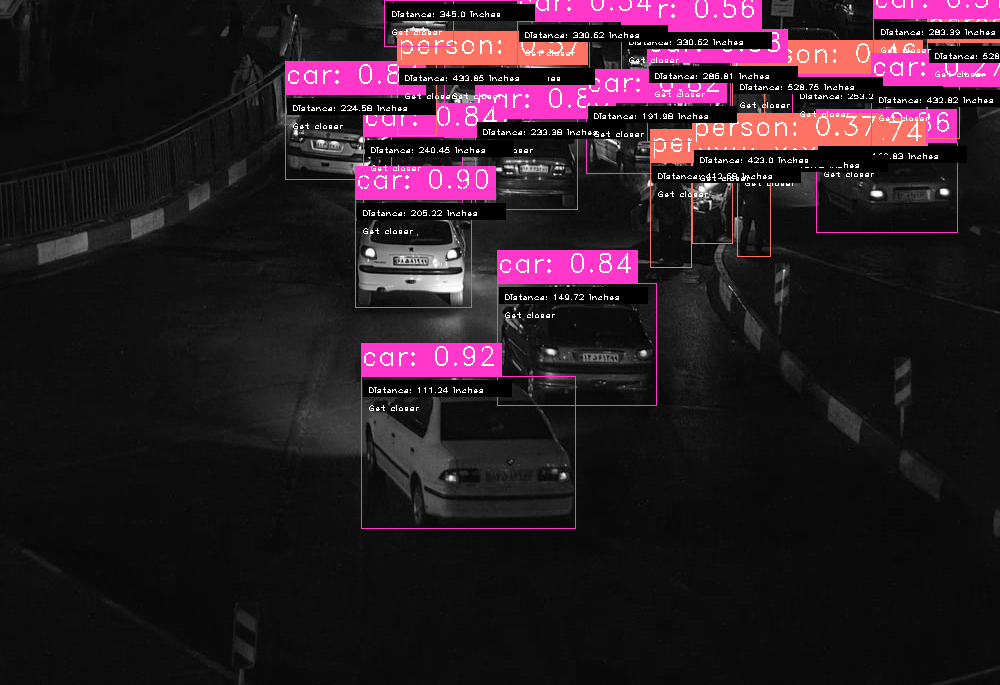

In [10]:
model_pytorch_path = Path("yolov8xcdark.pt")
model_pytorch = YOLO(model_pytorch_path)
img, result_list_json = image_processing(IMAGE_PATH, model_pytorch)

pil_img = Image.fromarray(img)
display(pil_img)

**Nightjars Optimized Model (OpenVINO)**

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion.

In [11]:
# object detection model
ov_path = Path("yolov8xcdark.xml")
if not ov_path.exists():
    model_pytorch.export(format="openvino", dynamic=True, half=True)

Ultralytics 8.3.7  Python-3.10.11 torch-2.4.1+cpu CPU (Intel Core(TM) Ultra 7 258V)

PyTorch: starting from 'yolov8xcdark.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (83.7 MB)

OpenVINO: starting export with openvino 2024.4.0-16579-c3152d32c9c-releases/2024/4...
OpenVINO: export success  3.6s, saved as 'yolov8xcdark_openvino_model\' (83.8 MB)

Export complete (4.5s)
Results saved to C:\Intel\aipcdevkit\openvino_notebooks\Nightjars_IntelAI
Predict:         yolo predict task=detect model=yolov8xcdark_openvino_model imgsz=640 half 
Validate:        yolo val task=detect model=yolov8xcdark_openvino_model imgsz=640 data=coco.yaml half 
Visualize:       https://netron.app


WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading yolov8xcdark_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

0: 640x640 1 person, 559.4ms
Speed: 2.0ms preprocess, 559.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cell phone, 1085.3ms
Speed: 2.0ms preprocess, 1085.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 chair, 2 tvs, 85.9ms
Speed: 2.0ms preprocess, 85.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 24.7ms
Speed: 2.0ms preprocess, 24.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Reference images processed successfully

0: 640x640 6 persons, 14 cars, 21.1ms
Speed: 3.0ms preprocess, 21.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


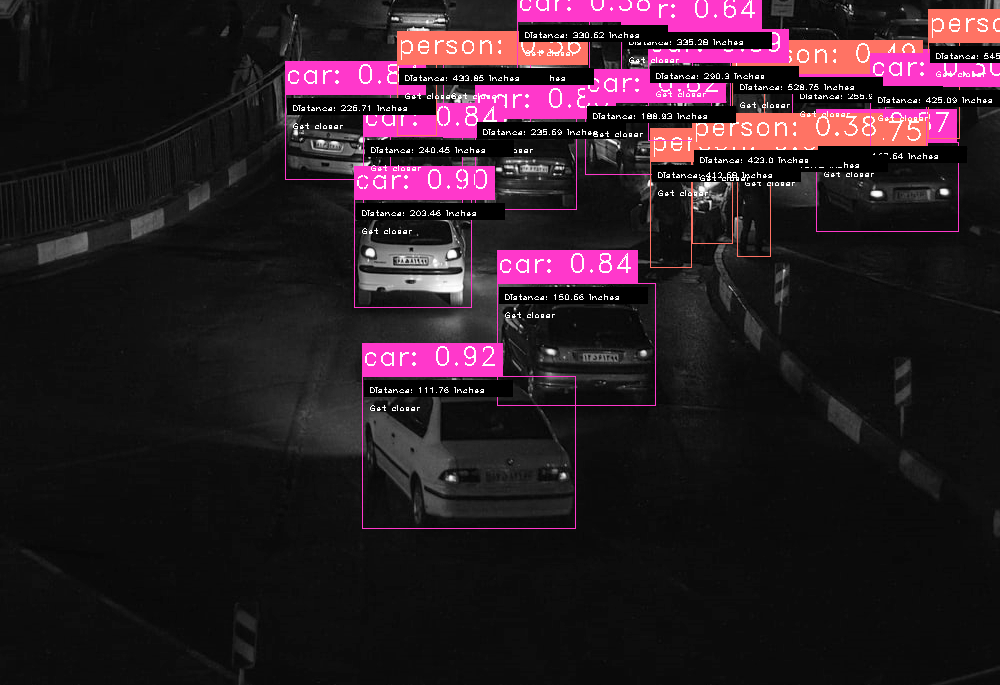

In [12]:
model_vino_path = Path("yolov8xcdark_openvino_model")
model_openvino = YOLO(model_vino_path)
img, result_list_json = image_processing(IMAGE_PATH, model_openvino)

pil_img = Image.fromarray(img)
display(pil_img)

### Video **Detections**

In [15]:
def video_processing(video_file, model, image_viewer=view_result_default, tracker=None, centers=None):
    """
    Process video file using ultralytics YOLOv8 model.
    Parameters:
        video_file: video file path
        model: ultralytics YOLOv8 model
        image_viewer: function to visualize result
        tracker: DeepSort tracker
        centers: list of deque of center points of bounding boxes
    Returns:
        video_file_name_out: name of output video file
        result_video_json_file: file containing detection result
    """
    # Initialize focal lengths if not already done
    if not hasattr(model, 'focal_lengths'):
        model.focal_lengths = initialize_focal_lengths(model)

    results = model.predict(video_file)
    model_name = model.ckpt_path.split('/')[-1].split('.')[0]

    output_folder = os.path.join('output_videos', os.path.splitext(os.path.basename(video_file))[0])
    os.makedirs(output_folder, exist_ok=True)
    video_file_name_out = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(video_file))[0]}_{model_name}_output.mp4")
    result_video_json_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(video_file))[0]}_{model_name}_output.json")

    # Try to remove existing files with proper error handling
    for file_path in [video_file_name_out, result_video_json_file]:
        try:
            if os.path.exists(file_path):
                os.remove(file_path)
        except PermissionError:
            print(f"Warning: Could not remove existing file {file_path}. It may be in use by another process.")
            # Try to create a new unique filename
            base, ext = os.path.splitext(file_path)
            timestamp = int(time.time())
            file_path = f"{base}_{timestamp}{ext}"
            if file_path == video_file_name_out:
                video_file_name_out = file_path
            else:
                result_video_json_file = file_path

    # Open JSON file with proper context manager
    with open(result_video_json_file, 'w') as json_file:
        first_frame = results[0].orig_img
        height, width = first_frame.shape[:2]

        # Initialize ffmpeg process
        process = subprocess.Popen(
            ['ffmpeg', '-y', '-f', 'rawvideo', '-vcodec', 'rawvideo',
             '-s', f'{width}x{height}', '-pix_fmt', 'bgr24', '-r', '30',
             '-i', '-', '-an', '-c:v', 'libx264', '-pix_fmt', 'yuv420p',
             video_file_name_out],
            stdin=subprocess.PIPE
        )

        result_list = []
        frame_count = 0

        try:
            for result in stqdm(results, desc="Processing video"):
                result_list_json = result_to_json(result, tracker=tracker)
                result_image = image_viewer(result, result_list_json, centers=centers)

                # Add distance estimation
                result_image = get_distance_info(result_list_json, result_image, model.focal_lengths)

                process.stdin.write(result_image.tobytes())
                result_list.append(result_list_json)
                frame_count += 1

            # Write results to JSON file
            json.dump(result_list, json_file, indent=2)

        except Exception as e:
            print(f"Error during video processing: {e}")
            raise
        finally:
            # Ensure proper cleanup
            process.stdin.close()
            process.wait()

    if frame_count == 0 or os.path.getsize(video_file_name_out) == 0:
        raise FileNotFoundError(f"The video file {video_file_name_out} was not created or is empty.")

    return video_file_name_out, result_video_json_file

In [16]:
from collections import deque

video_file_path = "assets/nighttestvideo.mp4"

tracker = DeepSort(max_age=50)

# Initialize centers (optional, for tracking visualization)
centers = [deque(maxlen=30) for _ in range(1000)]

# Call video_processing function
video_output_path, json_output_path = video_processing(
    video_file=video_file_path,
    model=model_openvino,
    image_viewer=view_result_default,  # Or view_result_ultralytics
    tracker=tracker,
    centers=centers
)

print(f"Processed video saved to: {video_output_path}")
print(f"JSON output saved to: {json_output_path}")



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/218) C:\Intel\aipcdevkit\openvino_notebooks\Nightjars_IntelAI\assets\nighttestvideo.mp4: 640x640 2 persons, 1 car, 22.9ms
video 1/1 (frame 2/218) C:\Intel\aipcdevkit\openvino_notebooks\Nightjars_IntelAI\assets\nighttestvideo.mp4: 640x640 2 persons, 19.5ms
video 1/1 (frame 3/218) C:\Intel\aipcdevkit\openvino_notebooks\Nightjars_IntelAI\assets\nighttestvideo.mp4: 640x640 1 person, 20.6ms
video 1/1 (frame 4/218) C:\Intel\aipcdevkit\openvi

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [17]:
from IPython.display import Video

video_path = video_output_path

display(Video(data=video_path, width=640, height=480, embed=True))

NameError: name 'video_output_path' is not defined

### **For Training yolov8 model- Ipex intel pytorch Optimization**

In [ ]:
!pip3 install intel-extension-for-pytorch torchvision torchaudio deepspeed --q

In [ ]:
from ultralytics import YOLO
import torch
import intel_extension_for_pytorch as ipex
 # Check for Intel GPU availability
device = torch.device('xpu' if torch.xpu.is_available() else 'cpu')
# Load the YOLOv8 model
model = YOLO('/content/Nightjars_IntelAI/yolov8xc.yaml')
torch_model = model.model
torch_model.eval()

# Apply IPEX optimization

optimized_ipex_model = ipex.llm.optimize(
    model, inplace=True, deployment_mode=True
)
print(optimized_ipex_model)


## **To run Nightjars on Streamlit**

In [ ]:
!pip install streamlit-autorefresh
!pip install streamlit-webrtc
!pip install pyngrok==7.2.0

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(port=8501)
print(f"Streamlit app is live at: {public_url}")

In [ ]:
!streamlit run /content/Nightjars_IntelAIstreamlit_app.py &>/dev/null &

## **Performance Metrics**